# ECG Heartbeat Categorization - Modeling


### Metric
The performance metric will be **Accuracy**. We will also look at **Precision, Recall/Sensitivity**, and **Specificity** 

### Algorithms
Non-Deep Learning:
* Decision Tree
* Random Forest
* XGBoost Classifier
* K-Nearest Neighbors Classifier
    
**Neural Network Architectures**:
* Single fully connected layer with same number of neurons as the input variables,
     one hidden layer with 512 neurons and softmax output layer.
* Second model with an additional hidden layer of 64 neurons and a dropout layer at (0.2)

**For 2D Convolutional Neural Network Architecture See Notebook:**
ECG_Heartbeat_Classification_2Dconv.04_Mod_def__train_2D_alone.ipynb
 
* Model 1 trained using 28 x 28 sized images
* Model 2 trained using 128 x 128 sized images

Principal Component Analysis performed for both models using variance >= 95%

In [1]:
# imports
import numpy as np
import pandas as pd
import os
#!pip install pandas-profiling
import pandas_profiling
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
import graphviz
import joblib
import pickle
%matplotlib inline

np.random.seed(123)

#!pip install scikit-learn
import sklearn
import scikitplot as skplt
import sklearn.feature_selection
from sklearn.preprocessing import label_binarize,OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



## Load Data

In [86]:
# Sampled dataset
### ECG_imgs_sampled.csv contains 128x128 scale images

ECG_imgs28_sampled = pd.read_csv('ECG_imgs28_sampled.csv')
ECG_imgs28_sampled.head(3)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,254.0,255.0,255.0,253.0,255.0,255.0,254.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0.0
1,255.0,254.0,255.0,255.0,253.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0.0
2,255.0,255.0,252.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0.0


In [185]:
ECG_imgs28_sampled.shape

(9999, 785)

In [186]:
#Split features and targets and make copy of df
X = ECG_imgs_sampled.drop('label',axis=1).copy() 
y = ECG_imgs_sampled['label'].copy()

In [187]:
#Check the shape of the features and targets
print(X.shape)

(9999, 784)


In [150]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
0,9999.0,254.644064,0.652922,251.0,254.0,255.0,255.0,255.0
1,9999.0,254.479648,0.835763,250.0,254.0,255.0,255.0,255.0
2,9999.0,254.489649,0.840481,248.0,254.0,255.0,255.0,255.0
3,9999.0,254.489949,0.892879,250.0,254.0,255.0,255.0,255.0
4,9999.0,254.454445,0.931705,250.0,254.0,255.0,255.0,255.0
...,...,...,...,...,...,...,...,...
779,9999.0,255.000000,0.000000,255.0,255.0,255.0,255.0,255.0
780,9999.0,255.000000,0.000000,255.0,255.0,255.0,255.0,255.0
781,9999.0,255.000000,0.000000,255.0,255.0,255.0,255.0,255.0
782,9999.0,255.000000,0.000000,255.0,255.0,255.0,255.0,255.0


In [188]:
print(y.shape)

(9999,)


In [152]:
y.describe().T

count    9999.000000
mean        0.459846
std         1.129610
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: label, dtype: float64

In [189]:
#Check for imbalanced data
y.value_counts()

0.0    8330
4.0     712
2.0     649
1.0     236
3.0      72
Name: label, dtype: int64

## There are Five Categories or Labels

* 0: N - Normal
* 1: S - Atrial premature
* 2: V - Premature ventricular contraction
* 3: F - Fusion of ventricular and normal
* 4: Q - Paced Unclassifiable 

## Label Mapping

In [190]:
# For class label mapping

class_label = {
    0: 'N - Normal',
    1: 'S - Atrial premature',
    2: 'V - Premature ventricular contraction',
    3: 'F - Fusion of ventricular and normal',
    4: 'Q - Paced Unclassifiable'
}

<AxesSubplot:xlabel='label', ylabel='count'>

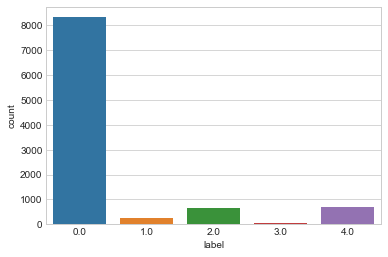

In [191]:
#!pip install seaborn
import seaborn as sns

#Plot the targets distribution
sns.countplot(x='label', data=ECG_imgs28_sampled)

In [192]:
import imblearn
from collections import Counter
print(imblearn.__version__)
counter = Counter(y)
print(counter)

0.7.0
Counter({0.0: 8330, 4.0: 712, 2.0: 649, 1.0: 236, 3.0: 72})


In [193]:
#Class distributions
import matplotlib.pyplot as pyplot
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))   

Class=0, n=8330 (83.308%)
Class=2, n=649 (6.491%)
Class=4, n=712 (7.121%)
Class=1, n=236 (2.360%)
Class=3, n=72 (0.720%)


## Balance the dataset
* Random Undersampling
* SMOTE - Synthetic Minority Oversampling Technique

In [ ]:
# Random Undersampling
## Note: Not using with 28 x 28 images increases model scores

from imblearn.under_sampling import RandomUnderSampler

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy= {0:2000})

# transform the dataset
X, y = undersample.fit_resample(X, y)

# summarize class distribution
#print(Counter(y))



# summarize class distribution

counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=0, n=8330 (20.000%)
Class=2, n=8330 (20.000%)
Class=4, n=8330 (20.000%)
Class=1, n=8330 (20.000%)
Class=3, n=8330 (20.000%)


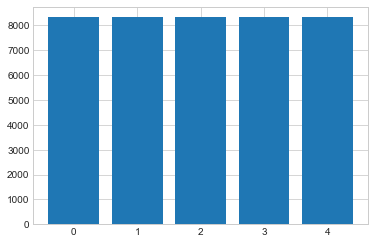

In [194]:
#SMOTE
# label encode the target variable
y = LabelEncoder().fit_transform(y)

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()    

In [195]:
print(X.shape)
print(y.shape)

(41650, 784)
(41650,)


In [196]:
# Normalize
X /= 255

In [197]:
X = np.array(X)
print(X.shape)

(41650, 784)


## Train Test Split

In [198]:
# Using 90% for training and 10% for testing
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y,train_size=0.9,random_state=0) 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [199]:
X_train.shape

(37485, 784)

In [200]:
X_test.shape

(4165, 784)

In [201]:
y_train.shape

(37485,)

In [202]:
y_test.shape

(4165,)

## PCA

In [203]:
from sklearn.decomposition import PCA

#Make an instance of the Model using 95% variance (.95) for example
# use square root of components for reshaping for 2D conv
# round up if float and rerun pca with new n_components

pca = PCA(.95)

In [204]:
#Fit PCA on training set
pca.fit(X_train)

PCA(n_components=0.95)

In [205]:
# Show number of components
pca.n_components_

183

In [206]:
#Apply the mapping (transform) to both the training set and the test set
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [207]:
print(X_train.shape)
print(X_test.shape)

(37485, 183)
(4165, 183)


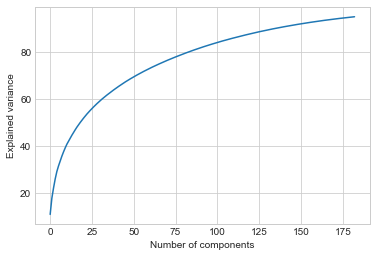

In [208]:
# Scree plot

plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.png')
plt.grid()

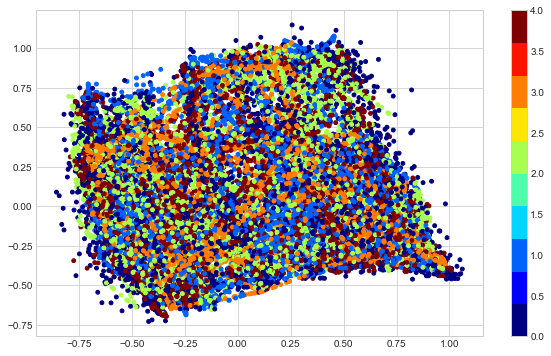

In [209]:
# Scatterplot (train set)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(X_train[:,0], X_train[:,1], s = 15,
            cmap = c_map , c = y_train)
plt.colorbar()
plt.show()

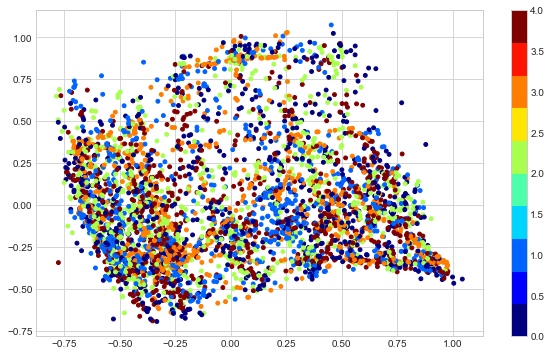

In [210]:
# Scatterplot (test set)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(X_test[:,0], X_test[:,1], s = 15,
            cmap = c_map , c = y_test)
plt.colorbar()
plt.show()

In [211]:
# Explained Variance

print(pca.explained_variance_)

[0.21561638 0.13412094 0.08528445 0.07568444 0.06246982 0.04676649
 0.04176758 0.03933023 0.03596094 0.03325853 0.03057656 0.02544107
 0.02504261 0.02449721 0.02317997 0.02237531 0.02170125 0.01994669
 0.01924717 0.01848297 0.01782479 0.01736437 0.016433   0.01575595
 0.01495964 0.0148393  0.0139453  0.01386937 0.01329047 0.0128832
 0.01251054 0.01231002 0.01167515 0.01129828 0.01123648 0.01079537
 0.01070235 0.0105385  0.01028438 0.01014573 0.00991106 0.00973392
 0.00953481 0.00934781 0.00929567 0.00907075 0.00883044 0.00843913
 0.00831423 0.00822601 0.00810469 0.00790819 0.00780612 0.00767289
 0.00756669 0.00745418 0.00722763 0.00717333 0.00710453 0.00699957
 0.00688343 0.0067155  0.00667871 0.00650826 0.00639358 0.0063206
 0.00628155 0.0062416  0.00614035 0.00602648 0.00597125 0.00586625
 0.00575687 0.00571583 0.00565104 0.00561793 0.00554489 0.00549576
 0.00544409 0.00532022 0.00530923 0.00527128 0.00520164 0.00509643
 0.00504849 0.00501704 0.00494595 0.00486414 0.00482587 0.004790

# Model Definition and Training

## Decision Tree 

In [249]:
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
pred_dt = dt.predict(X_test)
pred2 = dt.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_dt)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_dt)))

Accuracy on train: 1.000
Accuracy on test: 0.807
Confusion Matrix:
[[397  91 145  31 162]
 [ 39 729  14   3  17]
 [ 68  21 695   5  42]
 [ 17   2   3 832   0]
 [ 87  18  36   4 707]]


In [250]:
print("dt:",classification_report(y_test, pred_dt))

dt:               precision    recall  f1-score   support

           0       0.65      0.48      0.55       826
           1       0.85      0.91      0.88       802
           2       0.78      0.84      0.81       831
           3       0.95      0.97      0.96       854
           4       0.76      0.83      0.79       852

    accuracy                           0.81      4165
   macro avg       0.80      0.81      0.80      4165
weighted avg       0.80      0.81      0.80      4165



Text(0.5, 19.5, 'Predicted Class')

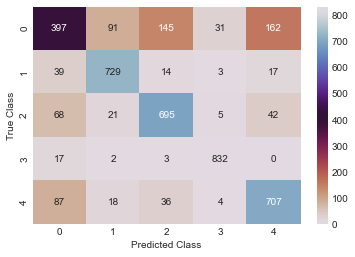

In [251]:
cm = confusion_matrix(y_test,pred_dt)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight_r')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [252]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.93680743 0.96074933 0.94061188 0.98701299 0.93329309]
Specificity Mean: 0.951694942160246
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.48062954 0.90897756 0.83634176 0.97423888 0.82981221]
Recall/Sensitivity Mean: 0.8059999870863328
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.65296053 0.8466899  0.77827548 0.95085714 0.76185345]
Precision Mean: 0.798127297768606


## ROC scores

In [253]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = dt.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.878750 (macro),
0.878946 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.878847 (macro),
0.879237 (weighted by prevalence)


## ROC plot

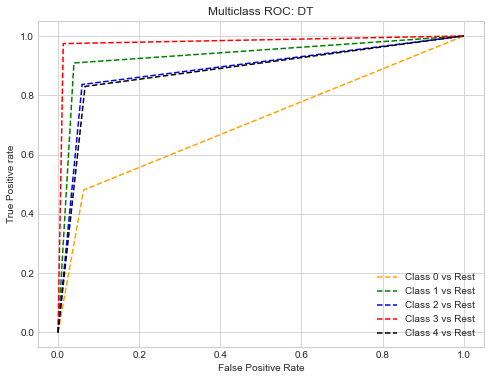

In [254]:
#ROC for multi-class classification model, Imbalanced data 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = dt.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC: DT')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## Predict and plot an example

The predicted class of the ECG Sample is: 2
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


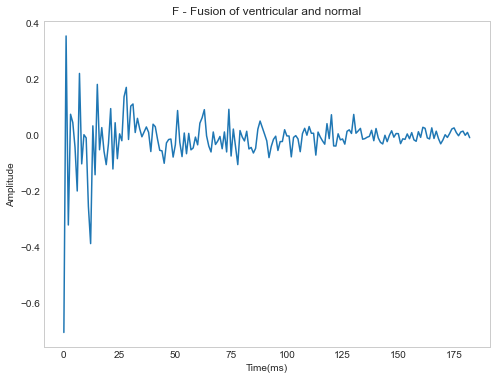

In [255]:
# Predict and plot example 
print('The predicted class of the ECG Sample is:', pred_dt[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Amplitude')
plt.xlabel('Time(ms)')
plt.grid()
plt.show()

**The prediction above is incorrect**

## Random Forest Classifier 

In [256]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1,criterion='gini')
rf.fit(X_train,y_train)
pred_rf= rf.predict(X_test)
pred2= rf.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_rf)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_rf)))

Accuracy on train: 0.999
Accuracy on test: 0.922
Confusion Matrix:
[[649  21  75   1  80]
 [  7 789   1   1   4]
 [ 48   6 771   0   6]
 [  0   0   0 854   0]
 [ 57   1  13   2 779]]


In [257]:
print("rf:",classification_report(y_test, pred_rf))

rf:               precision    recall  f1-score   support

           0       0.85      0.79      0.82       826
           1       0.97      0.98      0.97       802
           2       0.90      0.93      0.91       831
           3       1.00      1.00      1.00       854
           4       0.90      0.91      0.91       852

    accuracy                           0.92      4165
   macro avg       0.92      0.92      0.92      4165
weighted avg       0.92      0.92      0.92      4165



Text(0.5, 19.5, 'Predicted Class')

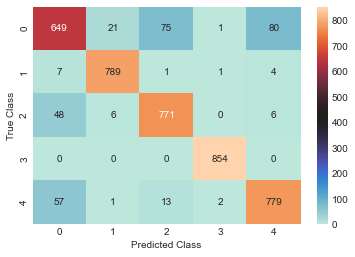

In [258]:
cm = confusion_matrix(y_test,pred_rf)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='icefire')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [259]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.96645702 0.9916741  0.97330534 0.99879191 0.97283429]
Specificity Mean: 0.9806125314862122
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.78571429 0.98379052 0.92779783 1.         0.91431925]
Recall/Sensitivity Mean: 0.9223243784332735
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.85282523 0.96572827 0.89651163 0.995338   0.89643268]
Precision Mean: 0.921367161724433


# ROC Scores

In [260]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = rf.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.988230 (macro),
0.988242 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.988223 (macro),
0.988263 (weighted by prevalence)


# ROC Plot

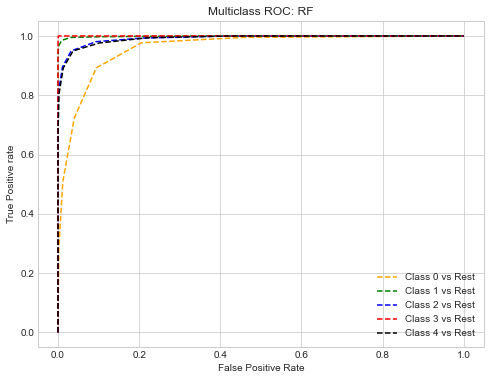

In [261]:
#ROC for multi-class classification model, Imbalanced data 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = rf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC: RF')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## Predict and plot an example

The predicted class of the ECG Sample is: 3
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


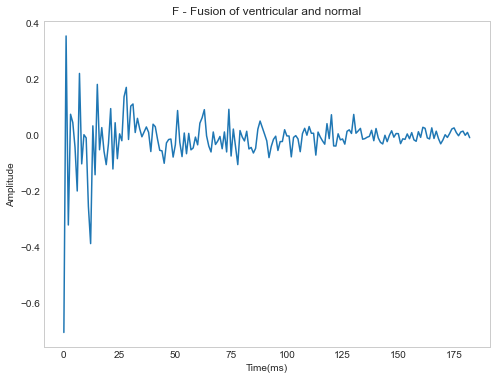

In [262]:
# Predict and plot example 
print('The predicted class of the ECG Sample is:', pred_rf[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Amplitude')
plt.xlabel('Time(ms)')
plt.grid()
plt.show()

## XGBoost

In [227]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=5,n_jobs=-1,booster = "gbtree",num_class = 5,
                    eval_metric = "mlogloss",objective = "multi:softprob")
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
pred2 = xgb.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_xgb)))
print('\n{}'.format(confusion_matrix(y_test,pred_xgb)))

Accuracy on train: 0.945
Accuracy on test: 0.899

[[606  42  74   4 100]
 [  1 792   3   1   5]
 [ 46  13 732   5  35]
 [  0   0   0 854   0]
 [ 50   8  32   3 759]]


In [228]:
print("xgb:",classification_report(y_test, pred_xgb))

xgb:               precision    recall  f1-score   support

           0       0.86      0.73      0.79       826
           1       0.93      0.99      0.96       802
           2       0.87      0.88      0.88       831
           3       0.99      1.00      0.99       854
           4       0.84      0.89      0.87       852

    accuracy                           0.90      4165
   macro avg       0.90      0.90      0.90      4165
weighted avg       0.90      0.90      0.90      4165



Text(0.5, 19.5, 'Predicted Class')

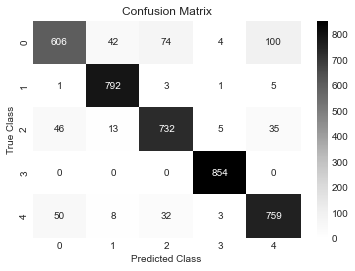

In [229]:
cm = confusion_matrix(y_test,pred_xgb)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='Greys')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [230]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.97094939 0.98126673 0.96730654 0.99607369 0.95774223]
Specificity Mean: 0.9746677144419531
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.73365617 0.98753117 0.88086643 1.         0.89084507]
Recall/Sensitivity Mean: 0.8985797685638562
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.86201991 0.92631579 0.87039239 0.98500577 0.84427141]
Precision Mean: 0.8976010547661024


### ROC for multi-class classification model

In [231]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = xgb.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.983204 (macro),
0.983203 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.983189 (macro),
0.983207 (weighted by prevalence)


### ROC plot

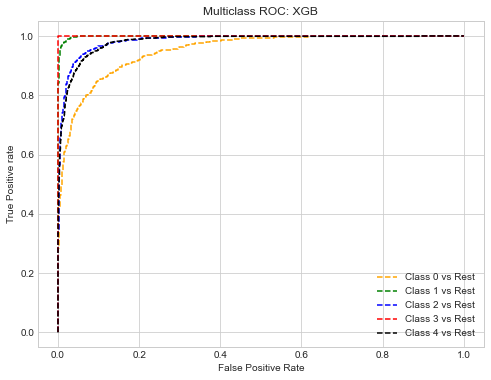

In [232]:
#ROC for multi-class classification model, Imbalanced data 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = xgb.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC: XGB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## Predict a single ECG sample and plot the selection

The predicted class of the ECG sample is: 3
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


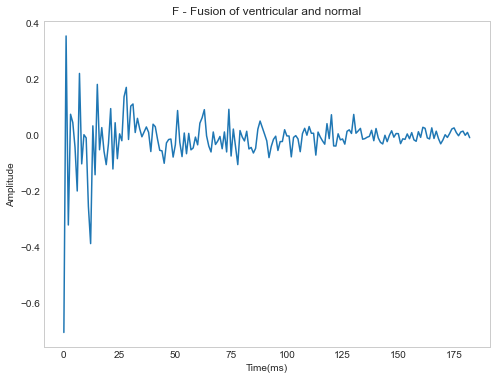

In [233]:
# Predict and plot example
print('The predicted class of the ECG sample is:', pred_xgb[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Amplitude')
plt.xlabel('Time(ms)')
plt.grid()
plt.show()

## KNN
**Nearest Neighbors Classification**

In [242]:
from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier(n_neighbors=5, n_jobs=-1).fit(X_train,y_train)

pred_knn = knn.predict(X_test)
pred2_knn = knn.predict(X_train)

#print("knn_Acc: {:.3f}".format(accuracy_score(y_test, predicted)))
#print("ConfMtx:\n{}".format(confusion_matrix(y_test,predicted)))

print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2_knn)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_knn)))
print('\n{}'.format(confusion_matrix(y_test,pred_knn)))

Accuracy on train: 0.893
Accuracy on test: 0.861

[[249  98 192  40 247]
 [  0 802   0   0   0]
 [  0   0 831   0   0]
 [  0   0   0 854   0]
 [  1   0   0   0 851]]


In [243]:
print("KNN:",classification_report(y_test, pred_knn))

KNN:               precision    recall  f1-score   support

           0       1.00      0.30      0.46       826
           1       0.89      1.00      0.94       802
           2       0.81      1.00      0.90       831
           3       0.96      1.00      0.98       854
           4       0.78      1.00      0.87       852

    accuracy                           0.86      4165
   macro avg       0.89      0.86      0.83      4165
weighted avg       0.89      0.86      0.83      4165



Text(0.5, 19.5, 'Predicted Class')

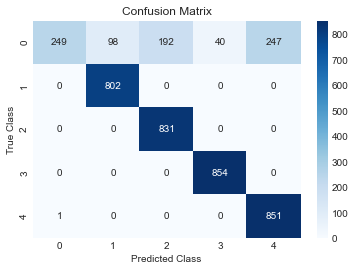

In [244]:
cm = confusion_matrix(y_test,pred_knn)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [245]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.99970051 0.97085935 0.94241152 0.98791906 0.92544522]
Specificity Mean: 0.9652671304206333
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.30145278 1.         1.         1.         0.99882629]
Recall/Sensitivity Mean: 0.8600558151166888
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.996      0.89111111 0.81231672 0.95525727 0.77504554]
Precision Mean: 0.8859461269375529


### ROC for multi-class classification model

In [246]:
# ROC AUC scores

from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = knn.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.964756 (macro),
0.964862 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.964798 (macro),
0.965023 (weighted by prevalence)


## ROC plot

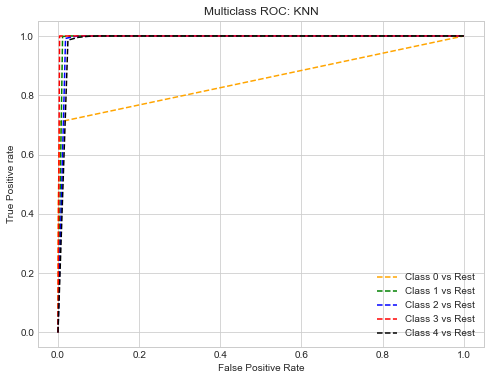

In [247]:
#ROC for multi-class classification model, Imbalanced data 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = knn.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC: KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## Predict a single ECG sample and plot the selection

The predicted class of the ECG sample is: 3
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


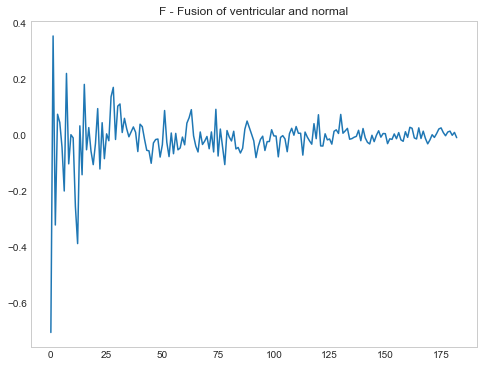

In [248]:
# Predict and plot example
print('The predicted class of the ECG sample is:', pred_knn[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
#plt.ylabel('Amplitude')
#plt.xlabel('Time(ms)')
plt.grid()
plt.show()

# Neural Network
### Baseline NN 

In [263]:
import tensorflow as tf
import keras
from keras.utils import plot_model
from keras import regularizers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,Conv1D,MaxPooling1D,AveragePooling1D,MaxPooling2D,AveragePooling2D
from keras.models import Sequential, load_model
from keras.utils.np_utils import to_categorical
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.core import Activation
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

In [264]:
X_train.shape

(37485, 183)

In [265]:
X_test.shape

(4165, 183)

In [266]:
y_train.shape

(37485,)

In [267]:
y_test.shape

(4165,)

In [268]:
n_cols = X_train.shape[1]
n_cols

183

## Baseline Neural Network 

In [269]:
batch_size = 320 #850
num_classes = 5 
epochs = 10

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(512, input_dim=(n_cols), activation='relu'))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

model = create_baseline()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               94208     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 2565      
Total params: 96,773
Trainable params: 96,773
Non-trainable params: 0
_________________________________________________________________


In [270]:
# evaluate model
estimator = KerasClassifier(build_fn=create_baseline, 
                            epochs=epochs, batch_size=batch_size, 
                           verbose=1)

kfold = StratifiedKFold(n_splits=4, shuffle=True)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)

Epoch 1/10
28113/28113 [==============================] - 1s 38us/step - loss: 1.4051 - accuracy: 0.4914
Epoch 2/10
28113/28113 [==============================] - 1s 27us/step - loss: 1.0231 - accuracy: 0.6351
Epoch 3/10
28113/28113 [==============================] - 1s 28us/step - loss: 0.8244 - accuracy: 0.7094 0s - loss: 0.8249 - accuracy: 0.70
Epoch 4/10
28113/28113 [==============================] - 1s 29us/step - loss: 0.6798 - accuracy: 0.7702
Epoch 5/10
28113/28113 [==============================] - 1s 28us/step - loss: 0.5612 - accuracy: 0.8269
Epoch 6/10
28113/28113 [==============================] - 1s 28us/step - loss: 0.4628 - accuracy: 0.8705
Epoch 7/10
28113/28113 [==============================] - 1s 30us/step - loss: 0.3827 - accuracy: 0.9036
Epoch 8/10
28113/28113 [==============================] - 1s 35us/step - loss: 0.3179 - accuracy: 0.9263
Epoch 9/10
28113/28113 [==============================] - 1s 35us/step - loss: 0.2652 - accuracy: 0.9430
Epoch 10/10
9372/937

In [271]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 93.20% (0.25%)


In [272]:
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=2,
                    validation_data= (X_test,y_test))

Train on 37485 samples, validate on 4165 samples
Epoch 1/10
 - 2s - loss: 1.3333 - accuracy: 0.5166 - val_loss: 1.0585 - val_accuracy: 0.6293
Epoch 2/10
 - 1s - loss: 0.9271 - accuracy: 0.6694 - val_loss: 0.8088 - val_accuracy: 0.7172
Epoch 3/10
 - 1s - loss: 0.7199 - accuracy: 0.7531 - val_loss: 0.6455 - val_accuracy: 0.7798
Epoch 4/10
 - 1s - loss: 0.5639 - accuracy: 0.8233 - val_loss: 0.5165 - val_accuracy: 0.8408
Epoch 5/10
 - 1s - loss: 0.4436 - accuracy: 0.8766 - val_loss: 0.4161 - val_accuracy: 0.8816
Epoch 6/10
 - 1s - loss: 0.3499 - accuracy: 0.9135 - val_loss: 0.3414 - val_accuracy: 0.9068
Epoch 7/10
 - 1s - loss: 0.2791 - accuracy: 0.9382 - val_loss: 0.2876 - val_accuracy: 0.9217
Epoch 8/10
 - 1s - loss: 0.2259 - accuracy: 0.9542 - val_loss: 0.2402 - val_accuracy: 0.9349
Epoch 9/10
 - 1s - loss: 0.1845 - accuracy: 0.9645 - val_loss: 0.2048 - val_accuracy: 0.9517
Epoch 10/10
 - 1s - loss: 0.1524 - accuracy: 0.9741 - val_loss: 0.1787 - val_accuracy: 0.9592


In [273]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)    
prediction_bl = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               94208     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 2565      
Total params: 96,773
Trainable params: 96,773
Non-trainable params: 0
_________________________________________________________________
None
train samples: 37485
test samples: 4165
Test loss: 0.17866909638458656
Test accuracy: 0.9591836929321289


In [274]:
print(classification_report(y_test.astype(int), prediction_bl))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       826
           1       0.99      1.00      0.99       802
           2       0.96      0.98      0.97       831
           3       0.99      1.00      1.00       854
           4       0.92      0.97      0.94       852

    accuracy                           0.96      4165
   macro avg       0.96      0.96      0.96      4165
weighted avg       0.96      0.96      0.96      4165



Text(0.5, 19.5, 'Predicted Class')

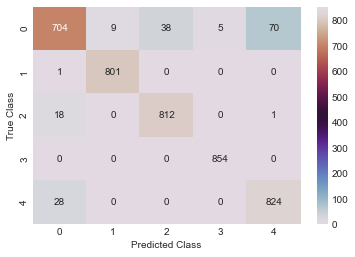

In [275]:
cm = confusion_matrix(y_test,prediction_bl)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [276]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.98592393 0.99732382 0.98860228 0.99848988 0.97856927]
Specificity Mean: 0.9897818363314634
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.85230024 0.99875312 0.97713598 1.         0.96713615]
Recall/Sensitivity Mean: 0.9590650980637129
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.93741678 0.98888889 0.95529412 0.99417928 0.92067039]
Precision Mean: 0.9592898906915457


## Visualize training and test histories

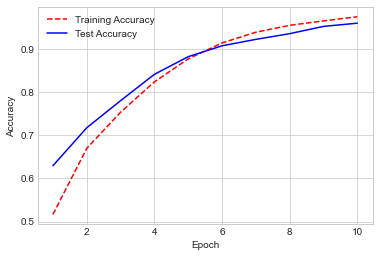

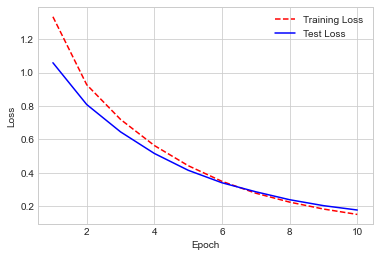

In [277]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification NN

In [278]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.995970 (macro),
0.995964 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.995955 (macro),
0.995958 (weighted by prevalence)


## ROC Plot

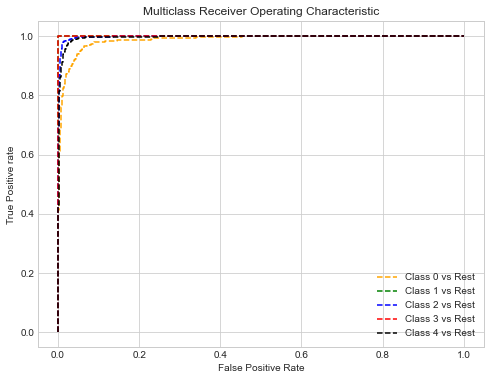

In [279]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Predict a single ECG sample and plot the selection

The predicted class of the ECG sample is: 3
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


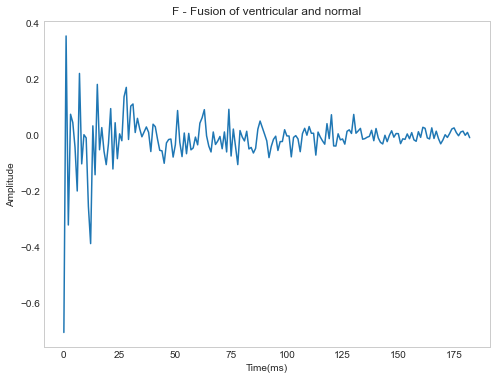

In [280]:
# Predict and plot example
print('The predicted class of the ECG sample is:', prediction_bl[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Amplitude')
plt.xlabel('Time(ms)')
plt.grid()
plt.show()

# Increased model complexity
* Added extra layer with 64 units 
* Added Dropout layer of .20    


## Neural Net 

In [281]:
batch_size = 320 #850
num_classes = 5 
epochs = 10
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10,restore_best_weights=True,
 verbose=1)

def create_cplx():
    
    #Create model
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(n_cols,))) 
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.20)) 
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model
   

model = create_cplx()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               94208     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 325       
Total params: 127,365
Trainable params: 127,365
Non-trainable params: 0
_________________________________________________________________


In [282]:
#evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_cplx, 
                           epochs=epochs, batch_size=batch_size, 
                           verbose=1)

kfold = StratifiedKFold(n_splits=4, shuffle=True)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)

Epoch 1/10
28113/28113 [==============================] - 1s 50us/step - loss: 1.3065 - accuracy: 0.4926
Epoch 2/10
28113/28113 [==============================] - 1s 34us/step - loss: 0.7896 - accuracy: 0.7032
Epoch 3/10
28113/28113 [==============================] - 1s 34us/step - loss: 0.5076 - accuracy: 0.8206
Epoch 4/10
28113/28113 [==============================] - 1s 35us/step - loss: 0.3284 - accuracy: 0.8909
Epoch 5/10
28113/28113 [==============================] - 1s 35us/step - loss: 0.2112 - accuracy: 0.9374
Epoch 6/10
28113/28113 [==============================] - 1s 35us/step - loss: 0.1387 - accuracy: 0.9636
Epoch 7/10
28113/28113 [==============================] - 1s 34us/step - loss: 0.0924 - accuracy: 0.9785
Epoch 8/10
28113/28113 [==============================] - 1s 38us/step - loss: 0.0671 - accuracy: 0.9857
Epoch 9/10
28113/28113 [==============================] - 1s 37us/step - loss: 0.0491 - accuracy: 0.9909
Epoch 10/10
9372/9372 [==============================] 

In [283]:
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 97.11% (0.30%)


In [284]:
history = model.fit(X_train, y_train, 
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[es],
                  verbose=1,
                  validation_data=(X_test, y_test))

Train on 37485 samples, validate on 4165 samples
Epoch 1/10
37485/37485 [==============================] - 2s 58us/step - loss: 1.1819 - accuracy: 0.5354 - val_loss: 0.7901 - val_accuracy: 0.7100
Epoch 2/10
37485/37485 [==============================] - 1s 36us/step - loss: 0.6463 - accuracy: 0.7518 - val_loss: 0.4880 - val_accuracy: 0.8218
Epoch 3/10
37485/37485 [==============================] - 2s 46us/step - loss: 0.3849 - accuracy: 0.8694 - val_loss: 0.2857 - val_accuracy: 0.9119
Epoch 4/10
37485/37485 [==============================] - 2s 46us/step - loss: 0.2202 - accuracy: 0.9351 - val_loss: 0.1724 - val_accuracy: 0.9513
Epoch 5/10
37485/37485 [==============================] - 2s 45us/step - loss: 0.1295 - accuracy: 0.9660 - val_loss: 0.1224 - val_accuracy: 0.9657
Epoch 6/10
37485/37485 [==============================] - 2s 46us/step - loss: 0.0836 - accuracy: 0.9803 - val_loss: 0.0890 - val_accuracy: 0.9760
Epoch 7/10
37485/37485 [==============================] - 2s 46us/ste

In [285]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)
prediction_cplx = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               94208     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 325       
Total params: 127,365
Trainable params: 127,365
Non-trainable params: 0
_________________________________________________________________
None
train samples: 37485
test samples: 4165
Test loss: 0.057708364412957736
Test accuracy: 0.981992781162262


In [286]:
print(classification_report(y_test.astype(int), prediction_cplx))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       826
           1       0.99      1.00      1.00       802
           2       0.98      0.99      0.99       831
           3       0.99      1.00      1.00       854
           4       0.96      0.99      0.98       852

    accuracy                           0.98      4165
   macro avg       0.98      0.98      0.98      4165
weighted avg       0.98      0.98      0.98      4165



Text(0.5, 19.5, 'Predicted Class')

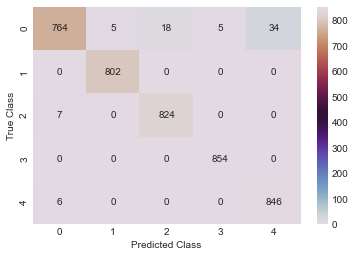

In [287]:
cm = confusion_matrix(y_test,prediction_cplx)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [288]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.99610662 0.99851323 0.99460108 0.99848988 0.9897374 ]
Specificity Mean: 0.9954896422209387
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.92493947 1.         0.99157641 1.         0.99295775]
Recall/Sensitivity Mean: 0.9818947255500614
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.98326898 0.99380421 0.97862233 0.99417928 0.96136364]
Precision Mean: 0.9822476877578324


## Visualize training and test histories

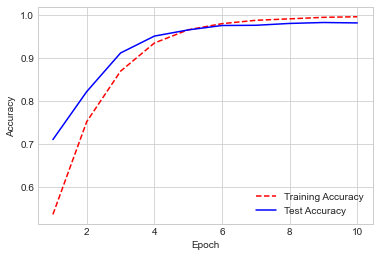

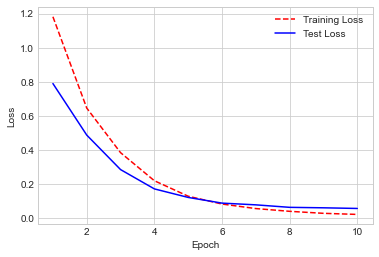

In [289]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification model

In [290]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.998795 (macro),
0.998795 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.998792 (macro),
0.998794 (weighted by prevalence)


### ROC plot

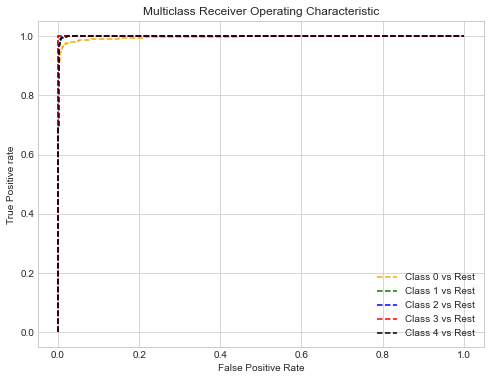

In [291]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Predict a single ECG sample and plot the selection

The predicted class of the ECG sample is: 3
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


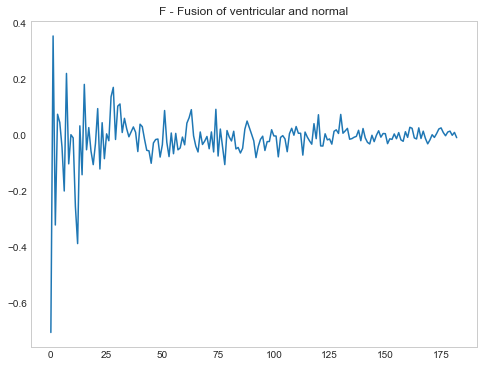

In [293]:
# Predict and plot example

prediction_cplx = model.predict_classes(X_test)

print('The predicted class of the ECG sample is:', prediction_cplx[8])
print('Class:',class_label)


plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
#plt.ylabel('Amplitude')
#plt.xlabel('Time(ms)')
plt.grid()
plt.show()

## To Save Neural Network

# To Save best Non-Time Series model

### Save the best model to pickle file

### Save best model using joblib